# Mobility and COVID-19 in London
#### This notebook looks for trends between mobility and COVID-19 cases in London

In [1]:
import pandas as pd
import zipfile
from io import StringIO
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression


## 1. Data

### 1.1. Load mobility data

In [2]:
# download mobility data from google:
# https://www.gstatic.com/covid19/mobility/Region_Mobility_Report_CSVs.zip

# open Great Britain mobility report from the zip file
mobility_archive = zipfile.ZipFile('DATA\Region_Mobility_Report_CSVs.zip', 'r')
bytes_data = mobility_archive.read('2020_GB_Region_Mobility_Report.csv')

# convert bytes to dataframe
string=str(bytes_data,'utf-8')
data = StringIO(string) 
gb_mobility=pd.read_csv(data)
gb_mobility.head(5)

country_region_code  country_region sub_region_1 sub_region_2  metro_area  \
0                  GB  United Kingdom          NaN          NaN         NaN   
1                  GB  United Kingdom          NaN          NaN         NaN   
2                  GB  United Kingdom          NaN          NaN         NaN   
3                  GB  United Kingdom          NaN          NaN         NaN   
4                  GB  United Kingdom          NaN          NaN         NaN   

  iso_3166_2_code  census_fips_code        date  \
0             NaN               NaN  2020-02-15   
1             NaN               NaN  2020-02-16   
2             NaN               NaN  2020-02-17   
3             NaN               NaN  2020-02-18   
4             NaN               NaN  2020-02-19   

   retail_and_recreation_percent_change_from_baseline  \
0                                              -12.0    
1                                               -7.0    
2                                               10.0    
3                                                7.0    
4                                                6.0    

   grocery_and_pharmacy_percent_change_from_baseline  \
0                                               -7.0   
1                                               -6.0   
2                                                1.0   
3                                               -1.0   
4                                               -2.0   

   parks_percent_change_from_baseline  \
0                               -35.0   
1                               -28.0   
2                                24.0   
3                                20.0   
4                                 8.0   

   transit_stations_percent_change_from_baseline  \
0                                          -12.0   
1                                           -7.0   
2                                           -2.0   
3                                           -3.0   
4                                           -4.0   

   workplaces_percent_change_from_baseline  \
0                                     -4.0   
1                                     -3.0   
2                                    -14.0   
3                                    -14.0   
4                                    -14.0   

   residential_percent_change_from_baseline  
0                                       2.0  
1                                       1.0  
2                                       2.0  
3                                       2.0  
4                                       3.0

In [3]:
# extract Greater London mobility (note: breakdown by borough exists, so exclude any rows with borough specified)
ldn_mobility = gb_mobility.loc[(gb_mobility['sub_region_1'] == 'Greater London') &
                                  (gb_mobility['sub_region_2'].isnull())].copy(deep=True)
ldn_mobility.reset_index(inplace=True)

# drop columns no needed, rename remaining columns
ldn_mobility = ldn_mobility.drop(columns=['index',
                                          'country_region_code',
                                          'country_region',
                                          'sub_region_1',
                                          'sub_region_2',
                                          'metro_area',
                                          'iso_3166_2_code',
                                          'census_fips_code'])
ldn_mobility.rename(columns={"date": "Date",
                             "retail_and_recreation_percent_change_from_baseline": "Retail&Recreation",
                             "grocery_and_pharmacy_percent_change_from_baseline": "Grocery&Pharmacy",
                             "parks_percent_change_from_baseline":"Parks",
                             "transit_stations_percent_change_from_baseline":"TransitStations",
                             "workplaces_percent_change_from_baseline":"Workplaces",
                             "residential_percent_change_from_baseline":"Residential"
                            }, inplace = True)

ldn_mobility.tail(5)

Date  Retail&Recreation  Grocery&Pharmacy  Parks  TransitStations  \
356  2021-02-05              -67.0             -16.0    2.0            -68.0   
357  2021-02-06              -70.0             -22.0  -28.0            -68.0   
358  2021-02-07              -75.0             -35.0  -48.0            -72.0   
359  2021-02-08              -69.0             -29.0  -18.0            -70.0   
360  2021-02-09              -70.0             -28.0  -27.0            -71.0   

     Workplaces  Residential  
356       -59.0         25.0  
357       -36.0         15.0  
358       -40.0         14.0  
359       -63.0         25.0  
360       -63.0         26.0

<AxesSubplot:xlabel='Date'>

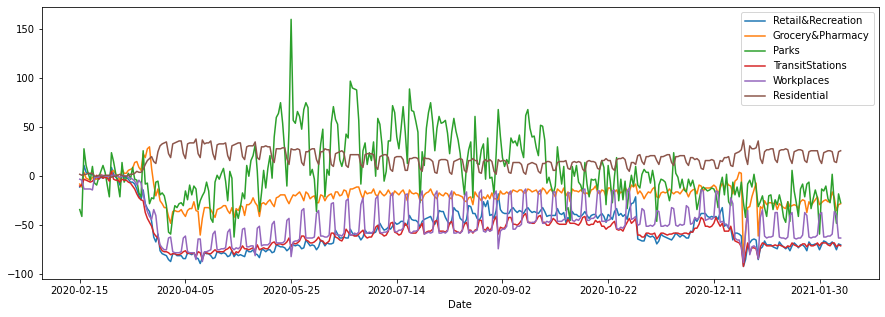

In [4]:
ldn_mobility.plot(x='Date', figsize=(15,5))

<AxesSubplot:xlabel='Date'>

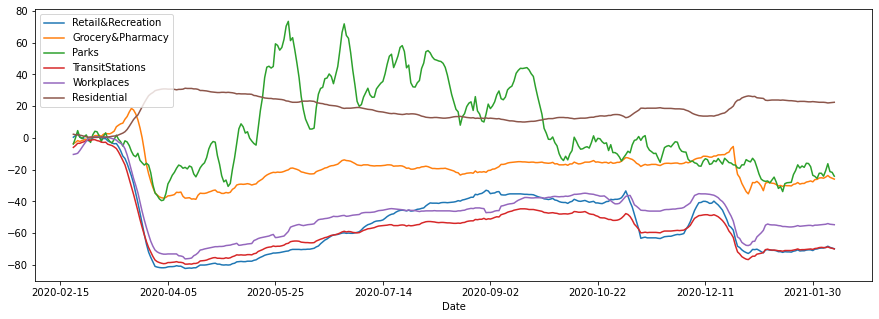

In [5]:
# mobility data appears to have clear weekly trends, so transform to seven day averages to smooth these out
ldn_mob_ma = ldn_mobility.copy(deep=True)
columns = list(ldn_mob_ma)[1:]
for c in columns:
    ldn_mob_ma[c] = ldn_mob_ma.loc[:,c].rolling(window=7).mean()

ldn_mob_ma.plot(x='Date', figsize=(15,5))

#### Some fairly intuitive trends in the mobility data emerge:
- Work/transit/retail seem closely correlated
- Residential seems inversely correlated with work/transit/retail
- Grocery/pharmacy less impacted by lockdown
- Parks more popular in during lockdown in summer. Fairly volatile though - perhaps driven by weather?

### 1.2. Load case data

In [6]:
# Load data set downloaded from here: 
# https://data.london.gov.uk/download/coronavirus--covid-19--cases/151e497c-a16e-414e-9e03-9e428f555ae9/phe_cases_london_boroughs.csv
ldn_cases_borough = pd.read_csv("DATA\phe_cases_london_boroughs.csv")
ldn_cases_borough.head(5)

area_name  area_code        date  new_cases  total_cases
0  Barking and Dagenham  E09000002  2020-01-31          0            0
1                Barnet  E09000003  2020-01-31          0            0
2                Bexley  E09000004  2020-01-31          0            0
3                 Brent  E09000005  2020-01-31          0            0
4               Bromley  E09000006  2020-01-31          0            0

In [7]:
# Add boroughs together to get total new london cases each day
ldn_cases_borough.drop(columns=['area_code', 'total_cases'], inplace = True)
ldn_cases = ldn_cases_borough.groupby(by='date').sum()
ldn_cases.reset_index(inplace=True)
ldn_cases.rename(columns={"date": "Date",
                          "new_cases": "NewCases"
                         }, inplace = True)
ldn_cases.head(5)

Date  NewCases
0  2020-01-31         1
1  2020-02-01         1
2  2020-02-02         0
3  2020-02-03         0
4  2020-02-04         0

<AxesSubplot:xlabel='Date'>

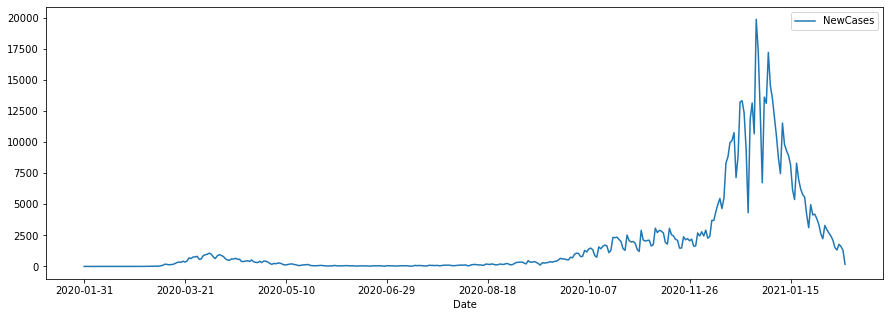

In [8]:
ldn_cases.plot(x='Date',figsize=(15,5))

<AxesSubplot:xlabel='Date'>

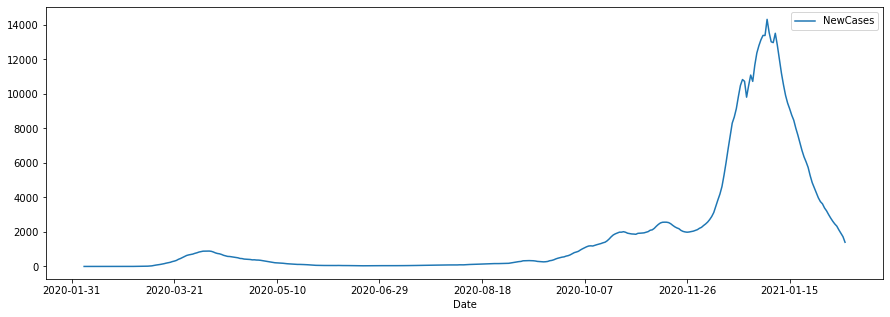

In [9]:
# daily case data looks to be impacted by weekly trends / can be lumpy, so take 7 day moving average
ldn_cases_ma = ldn_cases.copy(deep=True)
ldn_cases_ma['NewCases'] = ldn_cases_ma.loc[:,'NewCases'].rolling(window=7).mean()
ldn_cases_ma.plot(x='Date', figsize=(15,5))

## 1.3. Load death data

In [10]:
# download from: https://www.england.nhs.uk/statistics/statistical-work-areas/covid-19-daily-deaths/
ldn_deaths = pd.read_excel("DATA\COVID-19-total-announced-deaths-13-February-2021.xlsx",
                         sheet_name="Tab1a Deaths by region",
                         usecols = "B,F",   # B for date, F for London
                         skiprows = 17,
                         skipfooter = 4)

ldn_deaths.rename(columns={"Up to 01-Mar-20": "Date",
                          "0.2": "Deaths"},
                 inplace = True)

# convert datetime to string to match other datasets
ldn_deaths['Date'] = ldn_deaths['Date'].dt.strftime('%Y-%m-%d')



<AxesSubplot:xlabel='Date'>

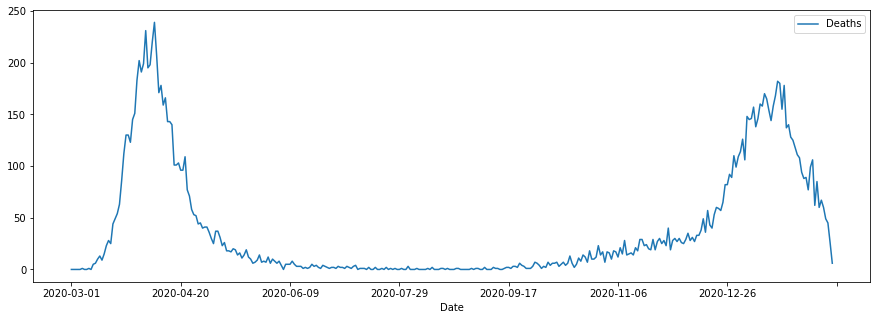

In [11]:
ldn_deaths.plot(x='Date',figsize=(15,5))

<AxesSubplot:xlabel='Date'>

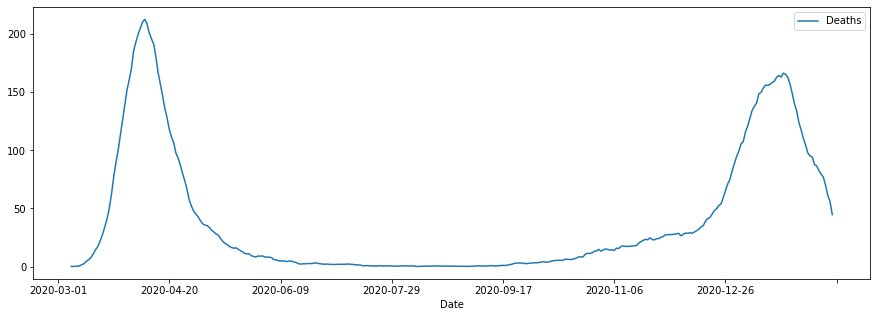

In [12]:
ldn_deaths_ma = ldn_deaths.copy(deep=True)
ldn_deaths_ma['Deaths'] = ldn_deaths_ma.loc[:,'Deaths'].rolling(window=7).mean()
ldn_deaths_ma.plot(x='Date', figsize=(15,5))

## 1.3. Load weather data

In [13]:
# download data from:
# https://meteostat.net/en/station/03772?t=2020-03-01/2021-01-23
ldn_weather = pd.read_csv("DATA\London-03772.csv")
ldn_weather.head(5)

date  tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun
0  2020-03-01   6.6   4.4  10.1   7.1   NaN  222.0  27.8   NaN   988.8   NaN
1  2020-03-02   5.7   3.8  10.1   5.1   NaN  223.0  14.1   NaN   990.4   NaN
2  2020-03-03   5.1   1.4  10.1   0.3   NaN  247.0  14.8   NaN  1002.5   NaN
3  2020-03-04   4.7  -0.1   8.0   0.8   NaN  138.0   9.2   NaN  1007.4   NaN
4  2020-03-05   5.7   5.0   6.1   5.6   NaN  112.0  16.4   NaN   995.1   NaN



## 2. Visualisation

### 2.1. Time series

In [14]:
# combine mobility and case data
ldn_data = ldn_mob_ma.copy(deep=True)
ldn_data = ldn_data.merge(ldn_cases_ma, left_on='Date', right_on='Date')


#combine with death data
ldn_data = ldn_data.merge(ldn_deaths_ma, left_on='Date', right_on='Date')

In [15]:
#drop any NaNs from moving average calcs
ldn_data.dropna(inplace=True)
ldn_data.reset_index(drop=True, inplace=True)

In [16]:
ldn_data.tail(5)

Date  Retail&Recreation  Grocery&Pharmacy      Parks  \
335  2021-02-05         -69.000000        -24.714286 -20.714286   
336  2021-02-06         -68.285714        -23.714286 -16.285714   
337  2021-02-07         -69.000000        -24.857143 -21.285714   
338  2021-02-08         -69.428571        -25.428571 -21.714286   
339  2021-02-09         -69.857143        -26.000000 -24.142857   

     TransitStations  Workplaces  Residential     NewCases     Deaths  
335       -69.142857  -54.428571    22.285714  2622.571429  86.571429  
336       -68.714286  -54.000000    22.000000  2464.142857  82.571429  
337       -69.285714  -54.428571    22.142857  2334.857143  79.428571  
338       -69.571429  -54.571429    22.285714  2118.000000  77.000000  
339       -70.000000  -54.714286    22.428571  1924.428571  69.857143

#### Some key UK/London COVID lockdown dates to consider
- 16 March 2020: UK enters national lockdown
- 15 June 2020: Non-essential shops re-opened on 15 June following the first wave. Begin of the analysis period
- August 2020: “Eat out to help out” scheme encouraging restaurant use
- 14 September 2020: “Rule of six” capping social meetings at 6 people
- 15 October 2020: London moved to “Tier 2”, further restricting meeting
- 5 November 2020: Begin of second UK national lockdown, including closing of all non-essential venues
- 2 December 2020: end of second national lockdown
- 20 December 2020: London enters Tier 4
- 6 January 2021: Begin of third UK national lockdown

In [17]:
# built mobility data line chart with plotly
fig = go.Figure()

# set up sub plots
fig = make_subplots(rows=3, cols=1, row_heights=[0.5, 0.25, 0.25],
                    subplot_titles=('Google mobility trends for Greater London',
                                    'Daily new COVID cases in Greater London',
                                    'Daily COVID deaths in Greater London')
                   )
fig.update_xaxes(title_text="Date", row=3, col=1)
fig.update_yaxes(title_text="7-day moving averages", row=2,col=1)



# add lines to upper subplot
fig.add_trace(go.Scatter(x = ldn_data['Date'], y=ldn_data['Retail&Recreation'],
                         mode = 'lines', name='Retail & Recreation'))
fig.add_trace(go.Scatter(x = ldn_data['Date'], y=ldn_data['Workplaces'], 
                         mode = 'lines', name='Workplaces'))
fig.add_trace(go.Scatter(x = ldn_data['Date'], y=ldn_data['TransitStations'], 
                         mode = 'lines',name='Transit Stations'))
fig.add_trace(go.Scatter(x = ldn_data['Date'], y=ldn_data['Grocery&Pharmacy'],
                         mode = 'lines',name='Grocery & Pharmacy'))
fig.add_trace(go.Scatter(x = ldn_data['Date'], y=ldn_data['Residential'],
                         mode = 'lines',name='Residential'))

# add lines to lower subplots
fig.add_trace(go.Scatter(x = ldn_data['Date'], y=ldn_data['NewCases'],
                         mode = 'lines',name='New Cases'), row=2, col=1)


fig.add_trace(go.Scatter(x = ldn_data['Date'], y=ldn_data['Deaths'],
                         mode = 'lines',name='Deaths'), row=3, col=1)


## Overlay national lockdowns
# UK National lockdown 1
fig.add_vrect(
    annotation_text="Lockdown 1", annotation_position="top left",
    x0="2020-03-16", x1="2020-06-15",
    fillcolor="salmon", opacity=0.5,
    layer="below", line_width=0,
),

# Eat out to help out
fig.add_vrect(
    annotation_text="Eat out to Help out", annotation_position="bottom left",
    x0="2020-08-01", x1="2020-08-31",
    fillcolor="darkseagreen", opacity=0.5,
    layer="below", line_width=0,
),

# UK National lockdown 2
fig.add_vrect(
    annotation_text="Lockdown 2", annotation_position="top left",
    x0="2020-11-5", x1="2020-12-02",
    fillcolor="salmon", opacity=0.5,
    layer="below", line_width=0,
),

# London Tier 4
fig.add_vrect(
    annotation_text="London Tier 4", annotation_position="bottom left",
    x0="2020-12-20", x1="2021-01-06",
    fillcolor="lightsalmon", opacity=0.5,
    layer="below", line_width=0,
),

# UK National lockdown 3
fig.add_vrect(
    annotation_text="Lockdown 3", annotation_position="top left",
    x0="2021-01-06", x1="2021-02-09",
    fillcolor="salmon", opacity=0.5,
    layer="below", line_width=0,
),


fig.update_layout(
    autosize=False,
    width=900,
    height=700,)

fig.show()

In [18]:
# built mobility data line chart with plotly
fig = go.Figure()

fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Change relative to baseline, 7-day avg")
fig.update_layout(title="Google mobility trends for Greater London")


# add lines
fig.add_trace(go.Scatter(x = ldn_data['Date'], y=ldn_data['Retail&Recreation'],
                         mode = 'lines', name='Retail & Recreation'))
fig.add_trace(go.Scatter(x = ldn_data['Date'], y=ldn_data['Workplaces'], 
                         mode = 'lines', name='Workplaces'))
fig.add_trace(go.Scatter(x = ldn_data['Date'], y=ldn_data['TransitStations'], 
                         mode = 'lines',name='Transit Stations'))
fig.add_trace(go.Scatter(x = ldn_data['Date'], y=ldn_data['Grocery&Pharmacy'],
                         mode = 'lines',name='Grocery & Pharmacy'))
fig.add_trace(go.Scatter(x = ldn_data['Date'], y=ldn_data['Residential'],
                         mode = 'lines',name='Residential'))


## Overlay national lockdowns
# UK National lockdown 1
fig.add_vrect(
    annotation_text="Lockdown 1", annotation_position="top left",
    x0="2020-03-16", x1="2020-06-15",
    fillcolor="salmon", opacity=0.5,
    layer="below", line_width=0,
),

# Eat out to help out
fig.add_vrect(
    annotation_text="Eat out to Help out", annotation_position="bottom left",
    x0="2020-08-01", x1="2020-08-31",
    fillcolor="darkseagreen", opacity=0.5,
    layer="below", line_width=0,
),

# UK National lockdown 2
fig.add_vrect(
    annotation_text="Lockdown 2", annotation_position="top left",
    x0="2020-11-5", x1="2020-12-02",
    fillcolor="salmon", opacity=0.5,
    layer="below", line_width=0,
),

# London Tier 4
fig.add_vrect(
    annotation_text="London Tier 4", annotation_position="bottom left",
    x0="2020-12-20", x1="2021-01-06",
    fillcolor="lightsalmon", opacity=0.5,
    layer="below", line_width=0,
),

# UK National lockdown 3
fig.add_vrect(
    annotation_text="Lockdown 3", annotation_position="top left",
    x0="2021-01-06", x1="2021-02-09",
    fillcolor="salmon", opacity=0.5,
    layer="below", line_width=0,
),


fig.update_layout(
    autosize=False,
    width=900,
    height=500,)

fig.show()

#### Some further observations on mobility data in light of the key government restrictions
- Despite London being in Tier 4 with no household mixing allowed, residential mobility increased over the Christmas period
- Residential mobility also increase in Lockdown 2, as venues closed and people met at each others' houses instead
- Lockdown 2 and Lockdown 3 did not lead to a similar run on grocery shops / pharmacies as seen at the start of Lockdown 1
- Tier 4 looks to have had a bigger impact on mobility than Lockdown 2, however Tier 4 included Christmas closures
- People use opportunity before they lose it: retail & recreation mobility peaked at the end of the eat-out-to-help-out scheme and just before Lockdown 2 commenced


### 2.2. Correlation heatmap

<AxesSubplot:>

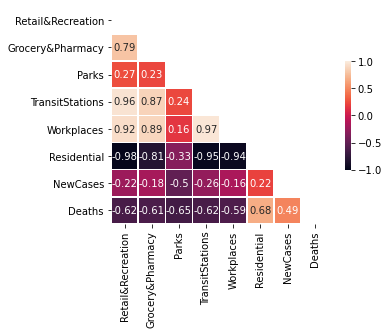

In [19]:
# find correlation
corr = ldn_data.corr()

# plot correlation triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, 
            vmax=1,
            vmin=-1,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5},
            annot=True
           )

#### Observations on these correlations
The correlations of New Cases with other variables are unhelpful in a few ways
- The strong relationship between parks and new cases could come from seasonality, as winter 2020 aproached and parks were less frequented & cases increased. Suggest ignoring parks for any further modelling
- The slight negative correlation with mobility impacted by lockdowns comes from

### 2.3. Let's investigate the correlation of time lags with the number of cases

In [20]:
# create a dataframe that has the correlations in it between NewCases and various lags of each mobility indicator

# initiate blank df to store results in
lagged_data = pd.DataFrame([])

# set number of lags and define mobility data to use
number_lags = 50
columns=["Retail&Recreation","Grocery&Pharmacy","Parks","TransitStations","Workplaces","Residential"]


# cycle over all columns
for column in columns:
    print("Adding", number_lags, "lags for:", column)

    # get a new df with NewCases in it
    ldn_data_lag = ldn_data['NewCases'].copy(deep=True).to_frame()

    # add the mobility data with various lags 
    for lag in range(0, number_lags + 1):
        ldn_data_lag[column + '_lag_' + str(lag)] = ldn_data[column].shift(lag)
    
    # work out correaltion
    corr = ldn_data_lag.corr().iloc[1:]

    #save to main correlation dataframe
    lagged_data[column] = corr['NewCases'].values
    
    
print("Size of new data set:", lagged_data.shape)

Adding 50 lags for: Retail&Recreation
Adding 50 lags for: Grocery&Pharmacy
Adding 50 lags for: Parks
Adding 50 lags for: TransitStations
Adding 50 lags for: Workplaces
Adding 50 lags for: Residential
Size of new data set: (51, 6)


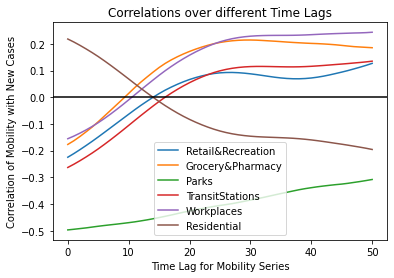

In [21]:
plt = lagged_data.plot(title = "Correlations over different Time Lags")
plt.set_xlabel("Time Lag for Mobility Series")
plt.set_ylabel("Correlation of Mobility with New Cases")
plt.axhline(y=0.0, color='black', linestyle='-')

Some observations on the lagged correlations:
- Park correlations are stong and negative for no lags, meaning on days where people went more to parks the number of new cases began to decrease
- Residential mobility has a strong positive correlation without lag, as lockdowns lead to an immediate increase in residential mobility as new cases are still rising
- For other mobility trends, there is a peak in positive correlation with about 20 days lag, suggesting it takes 20 days for a reduction in mobility to have the biggest impact on a reduction in new cases
- Other mobility trends also have a negative correlation at no lag, as new cases are typically still rising as a lockdown takes effect
- Overall, correlations aren't the strongest, as much of the data relates to periods of 'normality' where other non-mobility factors can have a large impact on new cases. Limiting the data set to the, say, 30 days after a lockdown could be interesting
- Furthermore, the low number of new cases in early 2020 vs late 2020/21 could be impact the Pearson correlation calculation as this is based on deviation relative to the mean. Looking at deaths, which were more fully documented early on, could be better

### 2.4. Correlation of time lags with the number of cases, considering only the periods after material travel restrictions are announced
This aims to investigate how many days after a mobility drop it takes for new cases to fall

In [53]:
# get a subset of the data set that covers 2 months after each lockdown

ldn_data_restrictions = ldn_data.copy(deep=True)
ldn_data_restrictions = ldn_data_restrictions[
    # UK Lockdown 1
    (ldn_data_restrictions['Date'] >= '2020-03-16') & 
    (ldn_data_restrictions['Date'] < '2020-05-16') |
    
    # UK Lockdown 2
    (ldn_data_restrictions['Date'] >= '2020-11-5') & 
    (ldn_data_restrictions['Date'] < '2021-01-5') |
    
    # London Tier 4 (transitions into UK Lockdown 3)
    (ldn_data_restrictions['Date'] >= '2020-12-20') & 
    (ldn_data_restrictions['Date'] < '2021-02-20')
]

ldn_data_restrictions.reset_index(drop = True, inplace = True)
ldn_data_restrictions.head(5)

Date  Retail&Recreation  Grocery&Pharmacy      Parks  \
0  2020-03-16         -13.000000         11.714286  -1.857143   
1  2020-03-17         -16.142857         13.428571  -2.571429   
2  2020-03-18         -20.000000         16.285714  -4.857143   
3  2020-03-19         -24.000000         18.571429  -8.428571   
4  2020-03-20         -28.714286         17.571429 -11.000000   

   TransitStations  Workplaces  Residential    NewCases     Deaths  
0       -17.000000   -6.857143     3.857143  160.142857   8.285714  
1       -21.285714  -10.714286     5.285714  191.428571  11.571429  
2       -26.000000  -15.428571     7.285714  216.000000  14.857143  
3       -30.857143  -20.571429     9.428571  240.000000  17.571429  
4       -35.571429  -25.571429    11.571429  281.714286  22.428571

In [54]:
# create a dataframe that has the correlations in it between NewCases and various lags of each mobility indicator

# initiate blank df to store results in
lagged_correlations = pd.DataFrame([])

# set number of lags and define mobility data to use
number_lags = 30
columns=["Retail&Recreation","Grocery&Pharmacy","TransitStations","Workplaces"]


# cycle over all columns
for column in columns:
    print("Adding", number_lags, "lags for:", column)

    # get a new df with NewCases in it
    ldn_data_lag = ldn_data_restrictions['NewCases'].copy(deep=True).to_frame()

    # add the mobility data with various lags 
    for lag in range(0, number_lags + 1):
        ldn_data_lag[column + '_lag_' + str(lag)] = ldn_data_restrictions[column].shift(lag)
    
    # work out correaltion
    corr = ldn_data_lag.corr().iloc[1:]

    #save to main correlation dataframe
    lagged_correlations[column] = corr['NewCases'].values
    
    
print("Size of new data set:", lagged_correlations.shape)

Adding 30 lags for: Retail&Recreation
Adding 30 lags for: Grocery&Pharmacy
Adding 30 lags for: TransitStations
Adding 30 lags for: Workplaces
Size of new data set: (31, 4)


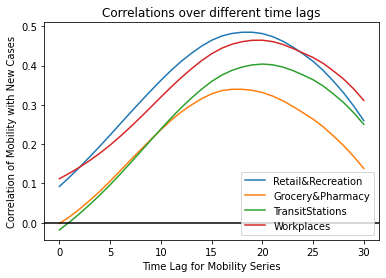

In [55]:
plt = lagged_correlations.plot(title = "Correlations over different time lags")
plt.set_xlabel("Time Lag for Mobility Series")
plt.set_ylabel("Correlation of Mobility with New Cases")
plt.axhline(y=0.0, color='black', linestyle='-')

Some comments on these correlations of different lags:
- Mobility changes have the most impact on new cases c15-20 later, i.e. it takes about 15-20 days for a new cases to really decrease 
- BUT: new cases here is a seven day moving average?!

In [56]:
lagged_correlations.head(5)

Retail&Recreation  Grocery&Pharmacy  TransitStations  Workplaces
0           0.092419         -0.001796        -0.018094    0.112255
1           0.116240          0.015230         0.001912    0.126228
2           0.141679          0.035235         0.023560    0.141715
3           0.168186          0.057154         0.046667    0.158640
4           0.195365          0.080339         0.070966    0.177287

### 2.5. Consider correlations without moving averages in the mobility and new case data

In [57]:
# create merged mobility/case data set without moving average calculations

ldn_data_daily = ldn_mobility.copy(deep=True)
ldn_data_daily = ldn_data_daily.merge(ldn_cases, left_on='Date', right_on='Date')
ldn_data_daily.head(5)

Date  Retail&Recreation  Grocery&Pharmacy  Parks  TransitStations  \
0  2020-02-15              -11.0              -8.0  -34.0            -10.0   
1  2020-02-16               -9.0             -11.0  -41.0             -9.0   
2  2020-02-17               11.0               4.0   28.0             -3.0   
3  2020-02-18                4.0              -2.0   11.0             -4.0   
4  2020-02-19                3.0              -3.0    3.0             -5.0   

   Workplaces  Residential  NewCases  
0        -3.0          2.0         0  
1        -4.0          1.0         0  
2       -13.0          2.0         0  
3       -13.0          2.0         0  
4       -13.0          3.0         0

In [58]:
# take subset of this data only for the 2 months after a lockdown was announced

ldn_data_restrictions = ldn_data_daily.copy(deep=True)
ldn_data_restrictions = ldn_data_restrictions[
    # UK Lockdown 1
    (ldn_data_restrictions['Date'] >= '2020-03-16') & 
    (ldn_data_restrictions['Date'] < '2020-05-16') |
    
    # UK Lockdown 2
    (ldn_data_restrictions['Date'] >= '2020-11-5') & 
    (ldn_data_restrictions['Date'] < '2021-01-5') |
    
    # London Tier 4 (transitions into UK Lockdown 3)
    (ldn_data_restrictions['Date'] >= '2020-12-20') & 
    (ldn_data_restrictions['Date'] < '2021-02-20')
]

ldn_data_restrictions.reset_index(drop = True, inplace = True)
ldn_data_restrictions.head(5)

Date  Retail&Recreation  Grocery&Pharmacy  Parks  TransitStations  \
0  2020-03-16              -14.0              23.0   26.0            -25.0   
1  2020-03-17              -28.0              19.0   -8.0            -37.0   
2  2020-03-18              -33.0              28.0   -7.0            -43.0   
3  2020-03-19              -36.0              30.0  -28.0            -47.0   
4  2020-03-20              -46.0               8.0  -22.0            -51.0   

   Workplaces  Residential  NewCases  
0       -18.0          7.0       233  
1       -29.0         12.0       311  
2       -36.0         16.0       355  
3       -41.0         18.0       332  
4       -44.0         20.0       426

In [50]:
# create a dataframe that has the correlations in it between NewCases and various lags of each mobility indicator

# initiate blank df to store results in
lagged_correls = pd.DataFrame([])

# set number of lags and define mobility data to use
number_lags = 30
columns=["Retail&Recreation","Grocery&Pharmacy","TransitStations","Workplaces"]


# cycle over all columns
for column in columns:
    print("Adding", number_lags, "lags for:", column)

    # get a new df with NewCases in it
    ldn_data_lag = ldn_data_restrictions['NewCases'].copy(deep=True).to_frame()

    # add the mobility data with various lags 
    for lag in range(0, number_lags + 1):
        ldn_data_lag[column + '_lag_' + str(lag)] = ldn_data_restrictions[column].shift(lag)
    
    # work out correaltion
    corr = ldn_data_lag.corr().iloc[1:]

    #save to main correlation dataframe
    lagged_correls[column] = corr['NewCases'].values
    
    
print("Size of new data set:", lagged_correls.shape)

Adding 30 lags for: Retail&Recreation
Adding 30 lags for: Grocery&Pharmacy
Adding 30 lags for: TransitStations
Adding 30 lags for: Workplaces
Size of new data set: (31, 4)


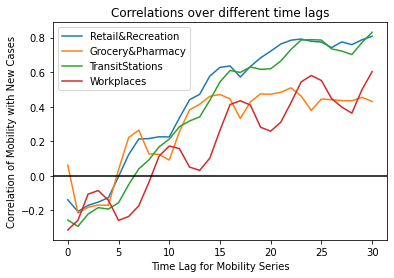

In [51]:
plt = lagged_correls.plot(title = "Correlations over different time lags")
plt.set_xlabel("Time Lag for Mobility Series")
plt.set_ylabel("Correlation of Mobility with New Cases")
plt.axhline(y=0.0, color='black', linestyle='-')

- Calculation correlations based on raw daily data for mobility and new cases (instead of data smoothed using 7-day moving averages) bring the correlation peaks in a little, closer to 15 days than 20 days
- Note that retail & recreation has a higher correlation early on. Less mobility to these venues seems to have a faster impact on reducing cases than other venues
- Grocery and pharmacy has less correlation - as these shops largely stay open anyway, and mobility continues

In [52]:
# build nicer chart
fig = go.Figure()

fig.update_xaxes(title_text="Days of lag applied to Mobility")
fig.update_yaxes(title_text="Correlation between Mobility and New Cases")
fig.update_layout(title="How long does it take for lower mobility to translate to lower new cases?")

# add lines to upper subplot
fig.add_trace(go.Scatter(y=lagged_correls['Retail&Recreation'],
                         mode = 'lines', name='Retail & Recreation'))
fig.add_trace(go.Scatter(y=lagged_correls['Grocery&Pharmacy'],
                         mode = 'lines', name='Grocery & Pharmacy'))
fig.add_trace(go.Scatter(y=lagged_correls['TransitStations'],
                         mode = 'lines', name='Transit Stations'))
fig.add_trace(go.Scatter(y=lagged_correls['Workplaces'],
                         mode = 'lines', name='Workplaces'))

# overlay peak correlation
fig.add_vrect(
    annotation_text="Peak correlation", annotation_position="bottom left",
    x0="14", x1="21",
    fillcolor="silver", opacity=0.5,
    layer="below", line_width=0,
),

fig.show()

### 2.5. Consider correlations without moving averages in the mobility and death data

In [31]:
# create merged mobility/case data set without moving average calculations, and based on death data
ldn_deaths_daily = ldn_mobility.copy(deep=True)
ldn_deaths_daily = ldn_deaths_daily.merge(ldn_deaths, left_on='Date', right_on='Date')
ldn_deaths_daily.head(5)

Date  Retail&Recreation  Grocery&Pharmacy  Parks  TransitStations  \
0  2020-03-01                9.0               4.0   24.0              5.0   
1  2020-03-02                2.0               6.0   15.0             -3.0   
2  2020-03-03               -1.0               2.0    3.0             -4.0   
3  2020-03-04               -3.0               1.0   -7.0             -4.0   
4  2020-03-05               -9.0              -5.0  -21.0             -6.0   

   Workplaces  Residential  Deaths  
0         1.0         -1.0       0  
1         1.0          0.0       0  
2         1.0          0.0       0  
3         0.0          1.0       0  
4        -1.0          2.0       0

In [32]:
# take subset of this data only for the 2 months after a lockdown was announced

ldn_deaths_restrictions = ldn_deaths_daily.copy(deep=True)
ldn_deaths_restrictions = ldn_deaths_restrictions[
    # UK Lockdown 1
    (ldn_deaths_restrictions['Date'] >= '2020-03-16') & 
    (ldn_deaths_restrictions['Date'] < '2020-05-16') |
    
    # UK Lockdown 2
    (ldn_deaths_restrictions['Date'] >= '2020-11-5') & 
    (ldn_deaths_restrictions['Date'] < '2021-01-5') |
    
    # London Tier 4 (transitions into UK Lockdown 3)
    (ldn_deaths_restrictions['Date'] >= '2020-12-20') & 
    (ldn_deaths_restrictions['Date'] < '2021-02-20')
]

ldn_deaths_restrictions.reset_index(drop = True, inplace = True)
ldn_deaths_restrictions.head(5)

Date  Retail&Recreation  Grocery&Pharmacy  Parks  TransitStations  \
0  2020-03-16              -14.0              23.0   26.0            -25.0   
1  2020-03-17              -28.0              19.0   -8.0            -37.0   
2  2020-03-18              -33.0              28.0   -7.0            -43.0   
3  2020-03-19              -36.0              30.0  -28.0            -47.0   
4  2020-03-20              -46.0               8.0  -22.0            -51.0   

   Workplaces  Residential  Deaths  
0       -18.0          7.0      15  
1       -29.0         12.0      23  
2       -36.0         16.0      28  
3       -41.0         18.0      25  
4       -44.0         20.0      44

In [33]:
# create a dataframe that has the correlations in it between NewCases and various lags of each mobility indicator

# initiate blank df to store results in
lagged_correls_deaths = pd.DataFrame([])

# set number of lags and define mobility data to use
number_lags = 40
columns=["Retail&Recreation","Grocery&Pharmacy","TransitStations","Workplaces"]


# cycle over all columns
for column in columns:
    print("Adding", number_lags, "lags for:", column)

    # get a new df with NewCases in it
    ldn_data_lag = ldn_deaths_restrictions['Deaths'].copy(deep=True).to_frame()

    # add the mobility data with various lags 
    for lag in range(0, number_lags + 1):
        ldn_data_lag[column + '_lag_' + str(lag)] = ldn_deaths_restrictions[column].shift(lag)
    
    # work out correaltion
    corr = ldn_data_lag.corr().iloc[1:]

    #save to main correlation dataframe
    lagged_correls_deaths[column] = corr['Deaths'].values
    
    
print("Size of new data set:", lagged_correls_deaths.shape)

Adding 40 lags for: Retail&Recreation
Adding 40 lags for: Grocery&Pharmacy
Adding 40 lags for: TransitStations
Adding 40 lags for: Workplaces
Size of new data set: (41, 4)


In [59]:
# build correlation chart

fig = go.Figure()

fig.update_xaxes(title_text="Days of lag applied to Mobility")
fig.update_yaxes(title_text="Correlation between Mobility and Deaths")
fig.update_layout(title="How long does it take for lower mobility to translate to lower deaths?")

# add lines to upper subplot
fig.add_trace(go.Scatter(y=lagged_correls_deaths['Retail&Recreation'],
                         mode = 'lines', name='Retail & Recreation'))
fig.add_trace(go.Scatter(y=lagged_correls_deaths['Grocery&Pharmacy'],
                         mode = 'lines', name='Grocery & Pharmacy'))
fig.add_trace(go.Scatter(y=lagged_correls_deaths['TransitStations'],
                         mode = 'lines', name='Transit Stations'))
fig.add_trace(go.Scatter(y=lagged_correls_deaths['Workplaces'],
                         mode = 'lines', name='Workplaces'))


# overlay peak correlation
fig.add_vrect(
    annotation_text="Peak correlation", annotation_position="bottom left",
    x0="21", x1="35",
    fillcolor="silver", opacity=0.5,
    layer="below", line_width=0,
),

fig.show()

### 2.5. Does Park mobility data depend on weather

In [35]:
# combine mobility and weather data
ldn_data_weather = ldn_mobility.copy(deep=True)
ldn_data_weather = ldn_data_weather.merge(ldn_weather, left_on='Date', right_on='date')

In [36]:
ldn_data_weather.head(5)

Date  Retail&Recreation  Grocery&Pharmacy  Parks  TransitStations  \
0  2020-03-01                9.0               4.0   24.0              5.0   
1  2020-03-02                2.0               6.0   15.0             -3.0   
2  2020-03-03               -1.0               2.0    3.0             -4.0   
3  2020-03-04               -3.0               1.0   -7.0             -4.0   
4  2020-03-05               -9.0              -5.0  -21.0             -6.0   

   Workplaces  Residential        date  tavg  tmin  tmax  prcp  snow   wdir  \
0         1.0         -1.0  2020-03-01   6.6   4.4  10.1   7.1   NaN  222.0   
1         1.0          0.0  2020-03-02   5.7   3.8  10.1   5.1   NaN  223.0   
2         1.0          0.0  2020-03-03   5.1   1.4  10.1   0.3   NaN  247.0   
3         0.0          1.0  2020-03-04   4.7  -0.1   8.0   0.8   NaN  138.0   
4        -1.0          2.0  2020-03-05   5.7   5.0   6.1   5.6   NaN  112.0   

   wspd  wpgt    pres  tsun  
0  27.8   NaN   988.8   NaN  
1  14.1   NaN   990.4   NaN  
2  14.8   NaN  1002.5   NaN  
3   9.2   NaN  1007.4   NaN  
4  16.4   NaN   995.1   NaN

In [37]:
# build chart

fig = go.Figure()


fig = make_subplots(rows=2, cols=1, row_heights=[0.5, 0.5],
                    subplot_titles=('Google mobility trends for Greater London', 'Weather data')
                   )

#fig.update_xaxes(title_text="Days of lag applied to Mobility")
#fig.update_yaxes(title_text="Correlation between Mobility and Deaths")
#fig.update_layout(title="How long does it take for lower mobility to translate to lower deaths?")

# add lines to upper subplot
fig.add_trace(go.Scatter(y=ldn_data_weather['Parks'],
                         mode = 'lines', name='Parks'))


# add lines to lower subplot
fig.add_trace(go.Scatter(y=ldn_data_weather['tavg'],
                         mode = 'lines', name='Average Temperature'), row=2, col=1)
fig.add_trace(go.Scatter(y=ldn_data_weather['tmax'],
                         mode = 'lines', name='Max Temperature'), row=2, col=1)
fig.add_trace(go.Scatter(y=ldn_data_weather['prcp'],
                         mode = 'lines', name='Precipitation'), row=2, col=1)




#fig.update_xaxes(title_text="Date", row=2, col=1)
#fig.update_yaxes(title_text="Change relative to baseline, 7-day avg", row=1, col=1)
#fig.update_yaxes(title_text="New COVID cases, 7-day avg", row=2, col=1)





fig.show()

<AxesSubplot:>

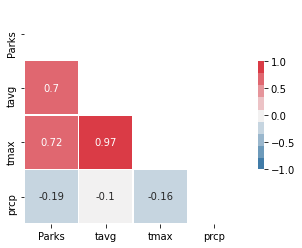

In [38]:
# find correlation
corr = ldn_data_weather[['Parks', 'tavg', 'tmax', 'prcp']].corr()

# plot correlation triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, 
            vmax=1,
            vmin=-1,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5},
            annot=True,
            cmap = sns.diverging_palette(240, 10, n=9)
           )

Not the strongest relationship between weather and park mobility, but:
- Sharp drops in mobility when there is rain
- Some increase when the weather is good
- Could be that the weather/park correlation is stronger on weekends, worth ivnestigating further

## 3. Predictive modelling

### 3.1. Lets start with a narrow scope first: how low does mobility have to be for daily case to declined materially

<AxesSubplot:>

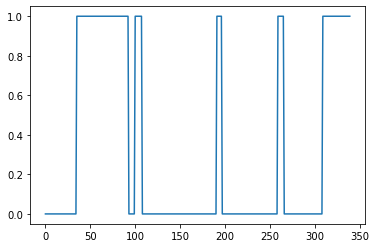

In [39]:
# work out oercentage change in new cases compared to one week prior
ldn_data_mat = ldn_data.copy(deep=True)
ldn_data_mat['NewCasesChange'] = ldn_data['NewCases'].pct_change(periods=7)

# define decrease materiality threshold
threshold = -0.1

# encode days with a material decrease as 1, otherwise as 0
ldn_data_mat['NewCasesMaterialDecrease'] = np.where(ldn_data_mat['NewCasesChange'] < threshold, 1, 0)
ldn_data_mat['NewCasesMaterialDecrease'].plot()

Doesn't feel like not enough for a test/train split, so will use all data to train for now

In [40]:
# get data for logistic regression
y = ldn_data_mat['NewCasesMaterialDecrease']
x = ldn_data_mat['TransitStations']

# format data for sk learn
y = y.to_numpy()
x = x.to_numpy()

y = y.reshape(-1,1).ravel()
x = x.reshape(-1,1)

In [41]:
# fit model
logreg = LogisticRegression()
logreg.fit(x, y)

# predict y for all data
y_pred = logreg.predict(x)
y_pred_proba = logreg.predict_proba(x)[:,1]

<AxesSubplot:>

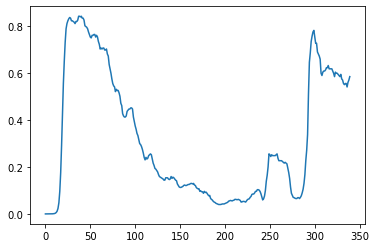

In [42]:
# combine actual and prediction into a df
logreg_output = pd.DataFrame({'Actual':y, 'Predicted':y_pred, 'PredictedProbability': y_pred_proba})

# plot prediction
logreg_output['PredictedProbability'].plot()